In [15]:
#Import all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging as log
import sys, os
import copy
import sys
import openpyxl
import time
%matplotlib inline


In [167]:
data_path  = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\Case study\Data"

metal_prices_df = pd.read_excel(data_path+"\\3_PR_mineral_price_v1.xlsx",sheet_name='values')
material_prices_df = pd.read_excel(data_path+"\\3_PR_material_price_mass_v1.xlsx", sheet_name='Values_Master')
historic_metal_prices = pd.read_excel(data_path+"\\3_PR_mineral_price_v1.xlsx",sheet_name='Historic')


In [172]:
print (material_prices_df[['Goods', 'Value', 'Unit', 'Source']].round(2).set_index('Goods').to_latex())

\begin{tabular}{lrll}
\toprule
{} &   Value &  Unit &                                             Source \\
Goods                                        &         &       &                                                    \\
\midrule
anode active material (natural graphite)     &    9.10 &  \$/kg &                     SMM, 3-1-22  high-end graphite \\
anode active material (synthetic graphite)   &   12.16 &  \$/kg &                     SMM, 3-1-22  high-end graphite \\
anode active material (SiO)                  &   60.00 &  \$/kg &                     Greenwood et al 2021 (Alibaba) \\
cathode active material (LMO)                &   10.98 &  \$/kg &               SMM, 3-1-22 (capacity grade for BEV) \\
cathode active material (LFP)                &   15.53 &  \$/kg &                                        SMM, 3-1-22 \\
cathode active material (NCA)                &   39.64 &  \$/kg &                           Calculated, see appendix \\
cathode active material (NMC333)            

In [161]:
material_prices = material_prices_df.set_index('Goods')['Value'].to_dict()
metal_prices = metal_prices_df.set_index('Mineral')['current'].to_dict()

In [162]:
def mineral_cost(molar_mass_df, metal_prices):
    """Process cost and profit margin estimation cathode active material
    cathode active material price calculation - data: 22-10-2021"""

    cathode_list = [
        "cathode active material (LFP)",
        "cathode active material (LMO)",
        "cathode active material (NMC333)",
        "cathode active material (NMC532)",
        "cathode active material (NMC622)",
        "cathode active material (NMC811)",
        "cathode active material (NCA)",
        "cathode active material (NMC532/50%/LMO  - )"

    ]
    cost_element = {}
    for cathode in cathode_list:
        cost_element[cathode] = {}
        for element in molar_mass_df.loc[cathode].set_index("Element").index:
            if element == "all":
                continue
            cost_element[cathode][element] = (
                molar_mass_df.loc[cathode]
                .set_index("Element")
                .loc[element, "Value"]
                * metal_prices[element]
                )

    return cost_element


def total_metal_cost(cost_element):
    total_dict = {}
    for k, v in cost_element.items():
        total_dict[k] = sum(v.values())
    return total_dict


def process_cost_profit_margin_cam(molar_mass_df, cam_prices, metal_prices, return_pcpm=False):
    cost_elements = mineral_cost(molar_mass_df, metal_prices)
    metal_cost = total_metal_cost(cost_elements)
    df = pd.DataFrame(
        index=metal_cost.keys(), columns=["Unit", "Li", "Co", "Mn", "Ni", "Fe", "P"]
    )
    df["Unit"] = "$/kg"
    
    
    for k in metal_cost.keys():
        df.loc[k, "Metal cost"] = metal_cost[k]
        for element, value in cost_elements[k].items():
            df.loc[k, element] = value
        if k not in cam_prices.keys():
            continue
        df.loc[k, "CAM price"] = cam_prices[k]
        df.loc[k, "PCPM"] = cam_prices[k] - metal_cost[k]
        
    if return_pcpm is True:
        return df['PCPM'].to_dict()
    # pd.DataFrame.from_dict(pcfm_dict, orient='index').rename({0:'Price (USD/kg)'}, axis=1),
    return df.fillna(0)

def cam_price (metal_cost, pcpm_cam, molar_mass):
    """Calculates the cathode active material price based on metal cost and process cost and profit margin

    Parameters
    ----------
    metal_price : [type]
        Metal price based on elemental value
    pcpm_cam : [type]
        process cost and profit margin for cathode active material
    molar_mass : 
        Molar mass of elements in cathode active material
    """
    cost_elements = mineral_cost(molar_mass, metal_cost)
    metal_cost = total_metal_cost(cost_elements)
    cam_price_dict = {}
    for k in pcpm_cam.keys():
        cam_price_dict [k] = metal_cost[k]+pcpm_cam[k]
    return cam_price_dict
    

In [32]:
df = pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\Case study\Data\3_MC_element_goods_v1.xlsx", sheet_name='Values_Master').set_index('Component')

In [41]:
cathode_list = [
        "cathode active material (LFP)",
        "cathode active material (LMO)",
        "cathode active material (NMC532)",
        "cathode active material (NMC622)",
        "cathode active material (NMC811)",
    ]

cam_prices = {x:material_prices[x] for x in cathode_list}


In [81]:
price = []

for x in historic_metal_prices [ 'Li']:
    metal_prices ['Ni'] = x
    price.append(cam_price (metal_prices,pcpm, df))

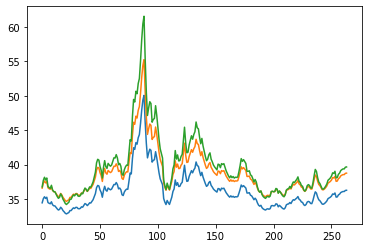

In [87]:
plt.plot([price[x]['cathode active material (NMC532)'] for x in range(0, len(price))])
plt.plot([price[x]['cathode active material (NMC622)'] for x in range(0, len(price))])
plt.plot([price[x]['cathode active material (NMC811)'] for x in range(0, len(price))])

In [165]:
pcpm = process_cost_profit_margin_cam(df, cam_prices, metal_prices, return_pcpm=False)
pcpm

,Unit,Li,Co,Mn,Ni,Fe,P,Metal cost,CAM price,PCPM,Al
cathode active material (LFP),$/kg,6.943348,0.000000,0.000000,0.000000,0.066784,0.24823,7.258362,15.53300,8.274638,0.000000
cathode active material (LMO),$/kg,6.845363,0.000000,2.859901,0.000000,0.000000,0.00000,9.705264,10.98298,1.277716,0.000000
cathode active material (NMC333),$/kg,12.250946,15.154352,0.892774,4.825714,0.000000,0.00000,33.123786,0.00000,0.000000,0.000000
cathode active material (NMC532),$/kg,12.231902,9.087564,0.803051,7.234553,0.000000,0.00000,29.357071,37.96972,8.612649,0.000000
cathode active material (NMC622),$/kg,12.185489,9.053082,0.533336,8.648522,0.000000,0.00000,30.420428,40.79391,10.373482,0.000000
cathode active material (NMC811),$/kg,12.142104,4.510425,0.265719,11.490307,0.000000,0.00000,28.408555,42.36291,13.954355,0.000000
cathode active material (NCA),$/kg,11.398777,7.020026,0.000000,11.922344,0.000000,0.00000,30.380558,0.00000,0.000000,0.039412
cathode active material (NMC532/50%/LMO - ),$/kg,6.447039,4.543782,1.831476,3.617277,0.000000,0.00000,16.439573,0.00000,0.000000,0.000000


In [164]:
metal_prices['Li'] *= 0.7
metal_prices
# cam_price(metal_prices,{'cathode active material (NMC333)':5.08}, df )

{'Ni': 24.393108745506282,
 'Al': 2.8075,
 'P': 1.2644727822580644,
 'Fe': 0.18864516129032255,
 'Cu': 9.7205,
 'C': 0.804,
 'Li': 157.83610646736784,
 'Si': 3.22206,
 'Mn': 4.8224832027012265,
 'Co': 76.31652215227462}

In [166]:
pcpm.loc['cathode active material (NMC333)', 'PCPM'] = 5.077717
pcpm.loc['cathode active material (NMC333)', 'CAM price'] = cam_price(metal_prices,{'cathode active material (NMC333)':5.077717}, df ).values()
pcpm.loc['cathode active material (NCA)', 'PCPM'] = 11.462241
pcpm.loc['cathode active material (NCA)', 'CAM price'] = cam_price(metal_prices,{'cathode active material (NCA)':7.192130}, df ).values()
pcpm.loc["cathode active material (NMC532/50%/LMO  - )", 'CAM price'] = (pcpm.loc['cathode active material (NMC532)', 'CAM price']*0.5)+pcpm.loc['cathode active material (LMO)', 'CAM price']*0.5
pcpm


,Unit,Li,Co,Mn,Ni,Fe,P,Metal cost,CAM price,PCPM,Al
cathode active material (LFP),$/kg,6.943348,0.000000,0.000000,0.000000,0.066784,0.24823,7.258362,15.533000,8.274638,0.000000
cathode active material (LMO),$/kg,6.845363,0.000000,2.859901,0.000000,0.000000,0.00000,9.705264,10.982980,1.277716,0.000000
cathode active material (NMC333),$/kg,12.250946,15.154352,0.892774,4.825714,0.000000,0.00000,33.123786,38.201503,5.077717,0.000000
cathode active material (NMC532),$/kg,12.231902,9.087564,0.803051,7.234553,0.000000,0.00000,29.357071,37.969720,8.612649,0.000000
cathode active material (NMC622),$/kg,12.185489,9.053082,0.533336,8.648522,0.000000,0.00000,30.420428,40.793910,10.373482,0.000000
cathode active material (NMC811),$/kg,12.142104,4.510425,0.265719,11.490307,0.000000,0.00000,28.408555,42.362910,13.954355,0.000000
cathode active material (NCA),$/kg,11.398777,7.020026,0.000000,11.922344,0.000000,0.00000,30.380558,37.572688,11.462241,0.039412
cathode active material (NMC532/50%/LMO - ),$/kg,6.447039,4.543782,1.831476,3.617277,0.000000,0.00000,16.439573,24.476350,0.000000,0.000000


,Element,Value,Unit,Source
Component,,,,
cathode active material (NMC811),Co,0.059102,kg,Molar weight
cathode active material (NMC811),Li,0.076929,kg,Molar weight
cathode active material (NMC811),Mn,0.055100,kg,Molar weight
cathode active material (NMC811),Ni,0.471047,kg,Molar weight
cathode active material (NMC811),all,1.000000,NaN,NaN


f = process_cost_profit_margin_cam (df, metal_price, cam_price )
f

In [26]:

def process_cost_profit_margin_cam (
    cam,
    metal_prices,
    coso_price=14.23944,
    niso_price=5.59407,
    mnso_price=1.52565,
    also_price=0.19,
):
    """Process cost and profit margin estimation cathode active material
    
    cathode active material price calculation - data: 22-10-2021"""
    M = {
        "Co": 58.933,
        "Ni": 58.693,
        "Mn": 54.938,
        "Li": 6.941,
        "Al": 26.982,
        "O": 15.999,
        "S": 32.065,
        "H": 1.0079,
        "C": 12.0107,
    }
    coso_mass = M["Co"] + M["S"] + M["O"] * 4 + (M["H"] * 2 + M["O"]) * 7
    niso_mass = M["Ni"] + M["S"] + M["O"] * 4 + (M["H"] * 2 + M["O"]) * 6
    mnso_mass = M["Mn"] + M["S"] + M["O"] * 4 + (M["H"] * 2 + M["O"])
    also_mass = (
        M["Al"]
        * 2
        / (M["Al"] * 2 + (M["S"] + M["O"] * 4) * 3 + (M["H"] * 2 + M["O"]) * 14)
    )
    lico_mass = M["Li"] * 2 / (M["Li"] * 2 + M["C"] + M["O"] * 3)

    co_content = molar_mass["Co"] / coso_mass
    ni_content = molar_mass["Ni"] / niso_mass
    mn_content = molar_mass["Mn"] / mnso_mass
    li_content = molar_mass["Li"] / lico_mass
    print(lico_mass)

    al_content = molar_mass["Al"] / also_mass

    co_price_share = coso_price / coso_mass
    ni_price_share = niso_price / niso_mass
    mn_price_share = mnso_price / mnso_mass
    al_price_share = also_price / also_mass
    li_price_share = lico_price / lico_mass

    return
